# Laboratorio 7
## Security Data Science
## Universidad del Valle de Guatemala

Andrés de la Roca - 20332

### Primera Parte - Creacion de la red neuronal

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator

In [18]:
path = './malimg_paper_dataset_imgs/'

In [19]:
familias = ImageDataGenerator().flow_from_directory(directory=path, target_size=(64,64), batch_size=10000)

Found 9339 images belonging to 25 classes.


In [20]:
familias.class_indices

{'Adialer.C': 0,
 'Agent.FYI': 1,
 'Allaple.A': 2,
 'Allaple.L': 3,
 'Alueron.gen!J': 4,
 'Autorun.K': 5,
 'C2LOP.P': 6,
 'C2LOP.gen!g': 7,
 'Dialplatform.B': 8,
 'Dontovo.A': 9,
 'Fakerean': 10,
 'Instantaccess': 11,
 'Lolyda.AA1': 12,
 'Lolyda.AA2': 13,
 'Lolyda.AA3': 14,
 'Lolyda.AT': 15,
 'Malex.gen!J': 16,
 'Obfuscator.AD': 17,
 'Rbot!gen': 18,
 'Skintrim.N': 19,
 'Swizzor.gen!E': 20,
 'Swizzor.gen!I': 21,
 'VB.AT': 22,
 'Wintrim.BX': 23,
 'Yuner.A': 24}

In [21]:
imgs, labels = next(familias)

In [22]:
imgs.shape

(9339, 64, 64, 3)

In [23]:
labels.shape

(9339, 25)

In [24]:
# plots images with labels within jupyter notebook
def plots(ims, figsize=(20,30), rows=10, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = 10 # len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(0,50):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(list(familias.class_indices.keys())[np.argmax(titles[i])], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

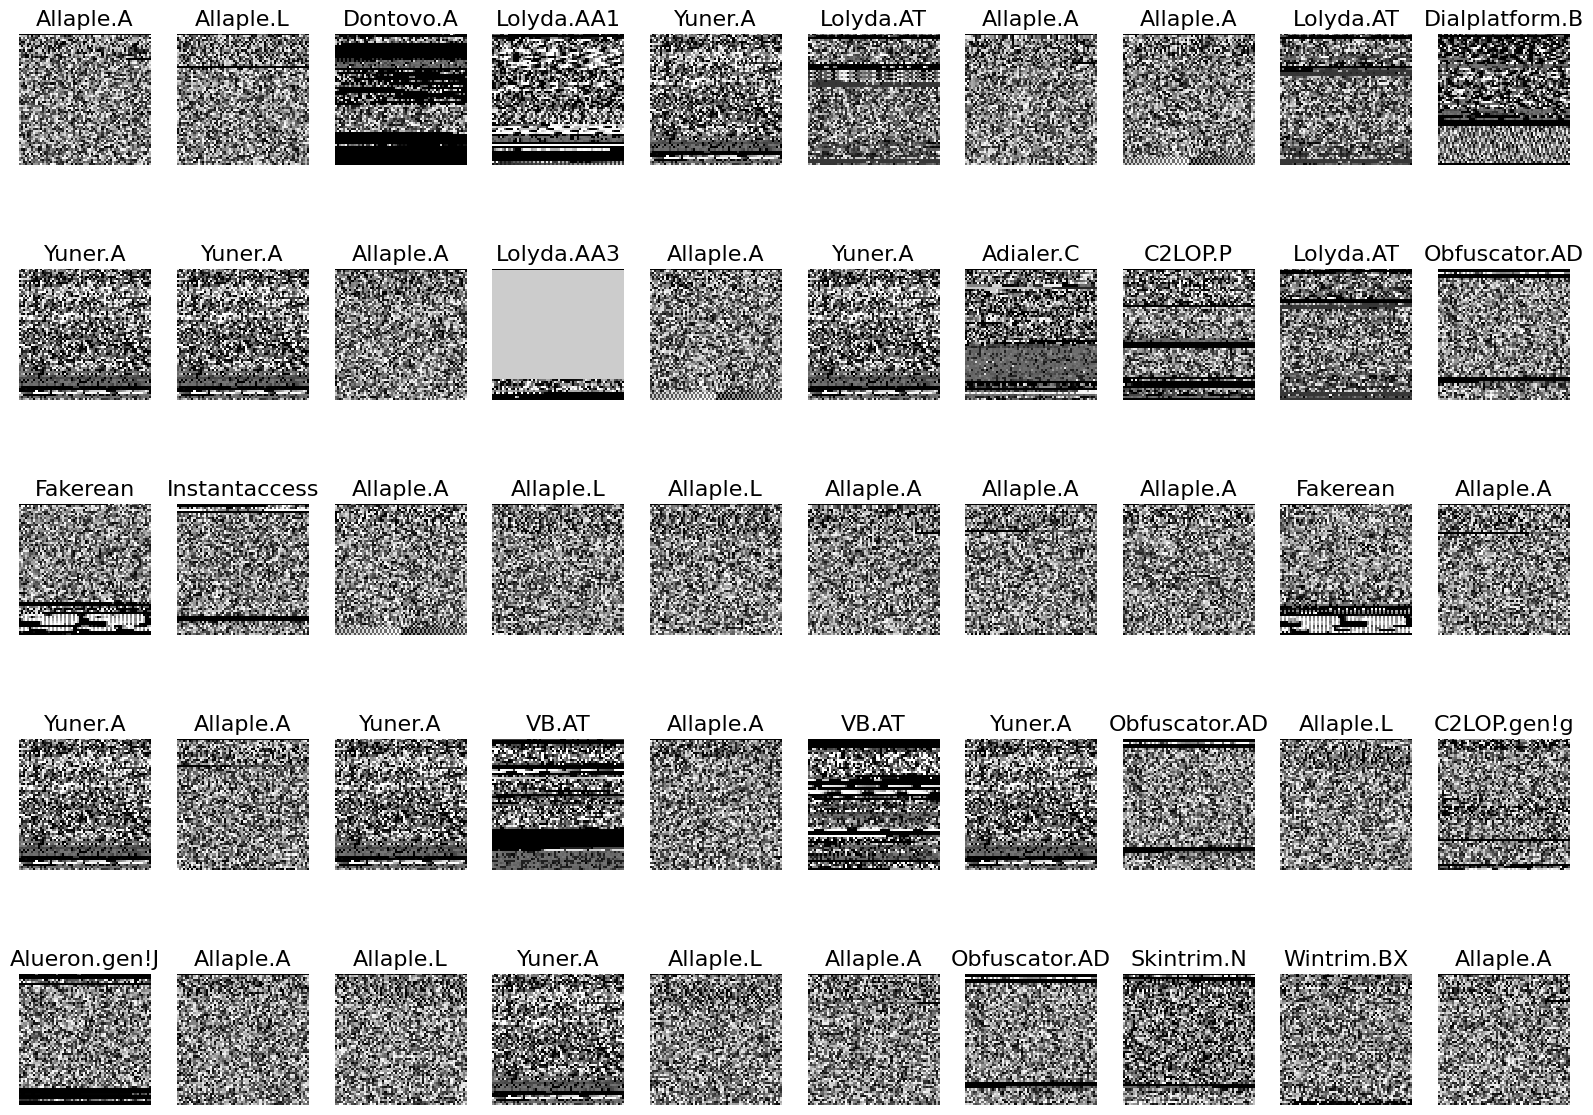

In [25]:

plots(imgs, titles = labels)

In [26]:
# 70% training, 30% testing
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(imgs, labels, test_size=0.3, random_state=42)

X_train.shape

(6537, 64, 64, 3)

In [27]:
# Funciones de graficación
def plot_loss(history): # Funcion para graficar la perdida
  plt.plot(history.history['loss'], label='train loss')
  plt.plot(history.history['val_loss'], label='val loss')
  plt.legend()
  plt.show()

def plot_accuracy(history): # Funcion para graficar la precision
  plt.plot(history.history['accuracy'], label='train acc')
  plt.plot(history.history['val_accuracy'], label='val acc')
  plt.legend()
  plt.show()

In [53]:
# Modelo para clasificacion de imagenes de malware
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.optimizers import Adam

epochs = 10 # Numero de epocas

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(25, activation='softmax'))
# opt = Adam(learning_rate=0.1)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')


In [54]:
history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_test, y_test))

Epoch 1/10
205/205 [==============================] - 15s 71ms/step - loss: 9.4987 - accuracy: 0.6200 - val_loss: 0.8847 - val_accuracy: 0.7812
Epoch 2/10
205/205 [==============================] - 13s 64ms/step - loss: 0.4471 - accuracy: 0.8767 - val_loss: 0.4498 - val_accuracy: 0.8897
Epoch 3/10
205/205 [==============================] - 14s 67ms/step - loss: 0.2829 - accuracy: 0.9260 - val_loss: 0.4857 - val_accuracy: 0.8779
Epoch 4/10
205/205 [==============================] - 13s 65ms/step - loss: 0.2389 - accuracy: 0.9376 - val_loss: 0.2948 - val_accuracy: 0.9343
Epoch 5/10
205/205 [==============================] - 13s 64ms/step - loss: 0.1674 - accuracy: 0.9556 - val_loss: 0.3334 - val_accuracy: 0.9143
Epoch 6/10
205/205 [==============================] - 13s 62ms/step - loss: 0.1376 - accuracy: 0.9625 - val_loss: 0.2770 - val_accuracy: 0.9375
Epoch 7/10
205/205 [==============================] - 14s 68ms/step - loss: 0.1091 - accuracy: 0.9648 - val_loss: 0.3237 - val_accuracy:

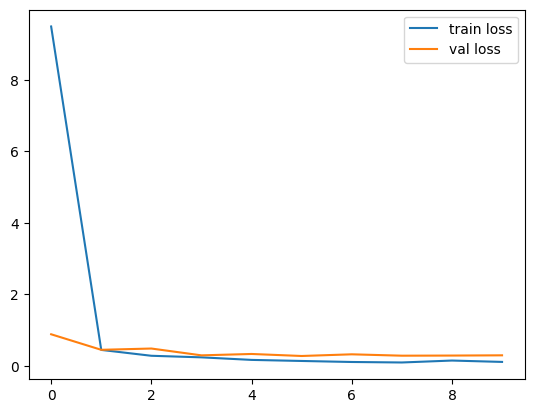

In [55]:
plot_loss(history)

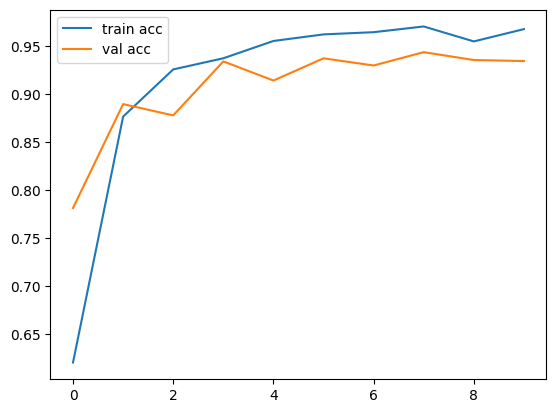

In [56]:
plot_accuracy(history)

In [57]:
results = model.evaluate(X_test, y_test)
print("Loss: ", results[0])
print("Accuracy: ", results[1])

88/88 [==============================] - 2s 17ms/step - loss: 0.2955 - accuracy: 0.9347
Loss:  0.2955452501773834
Accuracy:  0.9346895217895508


In [58]:
# Guardar el modelo
model.save('modelo_malimg.h5')
model.save('modelo_malimg.keras')